In [1]:
import pandas as pd
import pandas_profiling
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv('adult.csv')
data.head()

age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country income  
0              40  United-States  <=50K  
1              50  United-States  <=50K  
2              40  United-States   >50K  
3              40  United-States   >50K  
4              30  United-States  <=50K

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                48842 non-null int64
workclass          48842 non-null object
fnlwgt             48842 non-null int64
education          48842 non-null object
educational-num    48842 non-null int64
marital-status     48842 non-null object
occupation         48842 non-null object
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     48842 non-null object
income             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [7]:
data['workclass'].unique()

array(['Private', 'Local-gov', '?', 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [8]:
data['race'].unique()

array(['Black', 'White', 'Asian-Pac-Islander', 'Other',
       'Amer-Indian-Eskimo'], dtype=object)

In [11]:
pandas_profiling.ProfileReport(data)

В ходе анализа отчета можем заключить следующее: столбцы capital-gain  и capital-loss можем удалить, так как больше 90% значений в них нули. Имее 52 дубликатов от которых нужно избавиться.educational-num не несет смысловой нагрузки удаляем.не очень поняла про fnlwgt, с уровнем дохода явно не коррелирует, так что удалим. Возрастно плотно расположен в основном в пределах 40-45. Классыне сбалансированы, дохода меньше 50 почти втрое больше, чем больше 50. Некоторые native-country отсутствуют и обозначены как ?. Так как таких немного от общего количества (857), можно подумать над удалением таких строчек. В occupation также есть ?. Но так как таких строчек достаточно много (2809) можно оставить и заменить на undefined для ясности. Замена пропусков на ? встречается во многих категориальных переменных в датасете.

Посмотрим, в каких точно признаках, отсутствующие значения заменены на ? и сколько таких значений

In [9]:
data.apply(lambda x: x == '?').sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

Удалим строки с ? у native-country, так как таких строк относитель немного

In [33]:
len(data)

48842

In [6]:
data_clean = data.drop(data[data['native-country'].str.strip() == '?'].index)

In [42]:
len(data_clean)

47985

Удалим ненужные столбцы

In [7]:
data_clean.drop(['capital-gain', 'capital-loss','fnlwgt','educational-num'],axis=1, inplace=True)

In [8]:
data_clean.head()

age  workclass     education      marital-status         occupation  \
0   25    Private          11th       Never-married  Machine-op-inspct   
1   38    Private       HS-grad  Married-civ-spouse    Farming-fishing   
2   28  Local-gov    Assoc-acdm  Married-civ-spouse    Protective-serv   
3   44    Private  Some-college  Married-civ-spouse  Machine-op-inspct   
4   18          ?  Some-college       Never-married                  ?   

  relationship   race  gender  hours-per-week native-country income  
0    Own-child  Black    Male              40  United-States  <=50K  
1      Husband  White    Male              50  United-States  <=50K  
2      Husband  White    Male              40  United-States   >50K  
3      Husband  Black    Male              40  United-States   >50K  
4    Own-child  White  Female              30  United-States  <=50K

Кодируем значения

Для race gender income occupation relashionship применим LabelIncoder, для остальных One-Hot Encoder

In [9]:
le = LabelEncoder()

In [10]:
def label_value(data,le):
    print("Label {}".format(data.columns.values[0]))
    le.fit(data)
    print('Labeled classes {}'.format(le.classes_))
    return le.transform(data)

In [11]:
data_clean['labeled_gender'] = label_value(data_clean[['gender']],le)

Label gender
Labeled classes ['Female' 'Male']


In [12]:
data_clean['labeled_income'] = label_value(data_clean[['income']],le)

Label income
Labeled classes ['<=50K' '>50K']


In [13]:
data_clean['labeled_occupation'] = label_value(data_clean[['occupation']],le)

Label occupation
Labeled classes ['?' 'Adm-clerical' 'Armed-Forces' 'Craft-repair' 'Exec-managerial'
 'Farming-fishing' 'Handlers-cleaners' 'Machine-op-inspct' 'Other-service'
 'Priv-house-serv' 'Prof-specialty' 'Protective-serv' 'Sales'
 'Tech-support' 'Transport-moving']


In [14]:
data_clean['labeled_relationship'] = label_value(data_clean[['relationship']],le)

Label relationship
Labeled classes ['Husband' 'Not-in-family' 'Other-relative' 'Own-child' 'Unmarried' 'Wife']


In [15]:
data_clean.drop(['relationship','occupation','income','gender'],axis=1,inplace=True)

In [17]:
data_clean.head()

age  workclass     education      marital-status   race  hours-per-week  \
0   25    Private          11th       Never-married  Black              40   
1   38    Private       HS-grad  Married-civ-spouse  White              50   
2   28  Local-gov    Assoc-acdm  Married-civ-spouse  White              40   
3   44    Private  Some-college  Married-civ-spouse  Black              40   
4   18          ?  Some-college       Never-married  White              30   

  native-country  labeled_gender  labeled_income  labeled_occupation  \
0  United-States               1               0                   7   
1  United-States               1               0                   5   
2  United-States               1               1                  11   
3  United-States               1               1                   7   
4  United-States               0               0                   0   

   labeled_relationship  
0                     3  
1                     0  
2                     0  
3                     0  
4                     3

In [15]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47985 entries, 0 to 48841
Data columns (total 11 columns):
age                     47985 non-null int64
workclass               47985 non-null object
education               47985 non-null object
marital-status          47985 non-null object
race                    47985 non-null object
hours-per-week          47985 non-null int64
native-country          47985 non-null object
labeled_gender          47985 non-null int64
labeled_income          47985 non-null int64
labeled_occupation      47985 non-null int64
labeled_relationship    47985 non-null int64
dtypes: int64(6), object(5)
memory usage: 4.4+ MB


In [16]:
def hot_encode(df):
    obj_df = df.select_dtypes(include=['object'])
    return pd.get_dummies(df, columns=obj_df.columns)

In [17]:
data_clean = hot_encode(data_clean)

In [22]:
data_clean.head()

age  hours-per-week  labeled_gender  labeled_income  labeled_occupation  \
0   25              40               1               0                   7   
1   38              50               1               0                   5   
2   28              40               1               1                  11   
3   44              40               1               1                   7   
4   18              30               0               0                   0   

   labeled_relationship  workclass_?  workclass_Federal-gov  \
0                     3            0                      0   
1                     0            0                      0   
2                     0            0                      0   
3                     0            0                      0   
4                     3            1                      0   

   workclass_Local-gov  workclass_Never-worked  ...  native-country_Portugal  \
0                    0                       0  ...                        0   
1                    0                       0  ...                        0   
2                    1                       0  ...                        0   
3                    0                       0  ...                        0   
4                    0                       0  ...                        0   

   native-country_Puerto-Rico  native-country_Scotland  native-country_South  \
0                           0                        0                     0   
1                           0                        0                     0   
2                           0                        0                     0   
3                           0                        0                     0   
4                           0                        0                     0   

   native-country_Taiwan  native-country_Thailand  \
0                      0                        0   
1                      0                        0   
2                      0                        0   
3                      0                        0   
4                      0                        0   

   native-country_Trinadad&Tobago  native-country_United-States  \
0                               0                             1   
1                               0                             1   
2                               0                             1   
3                               0                             1   
4                               0                             1   

   native-country_Vietnam  native-country_Yugoslavia  
0                       0                          0  
1                       0                          0  
2                       0                          0  
3                       0                          0  
4                       0                          0  

[5 rows x 84 columns]

# Построение модели

In [18]:
y = data_clean['labeled_income']

In [19]:
X = data_clean.drop('labeled_income',axis=1)

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
data_clean = pd.DataFrame(scaler.transform(X),columns = X.columns.values)

In [22]:
X_train,  X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

#### Сначала получим оценки используя разные классификаторы и выберем классификатор с самой высокой оценкой. Используем все принаки

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [24]:
logreg = LogisticRegression(random_state = 121)

In [25]:
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)
scores = cross_val_score(clf,X_train, y_train,scoring = 'roc_auc',cv=5)
print('cv ACCURACY: %.3f +/- %.3f'% (np.mean(scores), np.std(scores)))

cv ACCURACY: 0.877 +/- 0.004


In [26]:
knn = KNeighborsClassifier()

In [27]:
hyperparameters = {'n_neighbors ' : [2,3,4,5], 'weights' : ['uniform', 'distance'], 'metric' : ['euclidean','manhattan']}
clf = GridSearchCV(knn, hyperparameters, cv=5, verbose=0)
scores = cross_val_score(knn,X_train, y_train,scoring = 'roc_auc',cv=5)
print('cv ACCURACY: %.3f +/- %.3f'% (np.mean(scores), np.std(scores)))

cv ACCURACY: 0.818 +/- 0.006


In [28]:
tree = DecisionTreeClassifier(random_state = 121)

In [29]:
hyperparameters = {'max_depth' : np.arange(1,20)}
clf = GridSearchCV(tree, hyperparameters, cv=5, verbose=0)
scores = cross_val_score(tree,X_train, y_train,scoring = 'roc_auc',cv=5)
print('cv ACCURACY: %.3f +/- %.3f'% (np.mean(scores), np.std(scores)))

cv ACCURACY: 0.724 +/- 0.004


Лучше всего себя проявила Логистическая регрессия. Воспользуемся ее для получения итоговых оценок.

Попробуем построить модель на подмножестве признаков. Для этого необходимо выяснить, какие признаки влияют на модель больше всего. 

Используем метод SelectKBEst

In [61]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [75]:
bestfeatures = SelectKBest(score_func=chi2, k=40)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores_40 = pd.concat([dfcolumns,dfscores],axis=1)
featureScores_40.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores_40.nlargest(40,'Score'))

                                   Specs         Score
0                                    age  12388.667347
1                         hours-per-week   9486.224227
4                   labeled_relationship   5476.500958
32     marital-status_Married-civ-spouse   5173.373565
34          marital-status_Never-married   3273.603740
26                     education_Masters   1384.026007
23                   education_Bachelors   1317.589727
28                 education_Prof-school   1143.467269
10                workclass_Self-emp-inc    898.629631
3                     labeled_occupation    785.670952
24                   education_Doctorate    749.086073
2                         labeled_gender    734.734347
30               marital-status_Divorced    684.716871
25                     education_HS-grad    545.603366
39                            race_Black    353.511579
15                        education_11th    351.364154
5                            workclass_?    317.793626
35        

In [74]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores_10 = pd.concat([dfcolumns,dfscores],axis=1)
featureScores_10.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores_10.nlargest(10,'Score'))

                                Specs         Score
0                                 age  12388.667347
1                      hours-per-week   9486.224227
4                labeled_relationship   5476.500958
32  marital-status_Married-civ-spouse   5173.373565
34       marital-status_Never-married   3273.603740
26                  education_Masters   1384.026007
23                education_Bachelors   1317.589727
28              education_Prof-school   1143.467269
10             workclass_Self-emp-inc    898.629631
3                  labeled_occupation    785.670952


Возьмем 10 признаков и половину признаков и посмотрим на оценки

In [90]:
X_40 = X[featureScores_40['Specs'].values]

In [91]:
X_train,  X_test, y_train, y_test = train_test_split(X_40 ,y, test_size = 0.3, random_state = 0)

In [92]:
logreg = LogisticRegression(random_state = 121)

In [97]:
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)
scores_40 = cross_val_score(clf,X_train, y_train,scoring = 'roc_auc',cv=5)
print('cv ACCURACY: %.10f +/- %.5f'% (np.mean(scores), np.std(scores)))

cv ACCURACY: 0.8769904692 +/- 0.00436


In [98]:
X_10 = X[featureScores_10['Specs'].values]

In [99]:
X_train,  X_test, y_train, y_test = train_test_split(X_10 ,y, test_size = 0.3, random_state = 0)

In [100]:
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)
scores_10 = cross_val_score(clf,X_train, y_train,scoring = 'roc_auc',cv=5)
print('cv ACCURACY: %.10f  +/- %.5f'% (np.mean(scores), np.std(scores)))

cv ACCURACY: 0.8769904692  +/- 0.00436


In [101]:
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores_5 = pd.concat([dfcolumns,dfscores],axis=1)
featureScores_5.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores_5.nlargest(5,'Score'))

                                Specs         Score
0                                 age  12388.667347
1                      hours-per-week   9486.224227
4                labeled_relationship   5476.500958
32  marital-status_Married-civ-spouse   5173.373565
34       marital-status_Never-married   3273.603740


In [102]:
X_5 = X[featureScores_5['Specs'].values]
X_train,  X_test, y_train, y_test = train_test_split(X_5 ,y, test_size = 0.3, random_state = 0)

In [103]:
penalty = ['l1', 'l2']
C = np.logspace(0, 5, 10)
hyperparameters = dict(C=C, penalty=penalty)
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)
scores_5 = cross_val_score(clf,X_train, y_train,scoring = 'roc_auc',cv=5)
print('cv ACCURACY: %.10f +/- %.5f'% (np.mean(scores), np.std(scores)))

cv ACCURACY: 0.8769904692 +/- 0.00436


In [105]:
scores_5 > scores_10

array([False, False, False,  True, False])

In [106]:
scores_40 > scores_10

array([False, False, False, False, False])

Можем видеть, что 10 признаков дают наилучшие результаты. Остановимся на них

#### Метрики качества модели

In [108]:
X_train,  X_test, y_train, y_test = train_test_split(X_10 ,y, test_size = 0.3, random_state = 0)

In [109]:
clf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=121, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e+00, 3.59381e+00, 1.29155e+01, 4.64159e+01, 1.66810e+02,
       5.99484e+02, 2.15443e+03, 7.74264e+03, 2.78256e+04, 1.00000e+05]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [113]:
bestlogreg = clf.best_estimator_
bestlogreg.fit(X_train,y_train)
bestlogreg.score(X_train,y_train)

0.8270564768227694

In [114]:
from sklearn.metrics import roc_curve

In [115]:
y_pred = bestlogreg.predict_proba(X_test)

In [116]:
fpr2, tpr2, thres2 = roc_curve( y_test,y_pred[:, 1] )

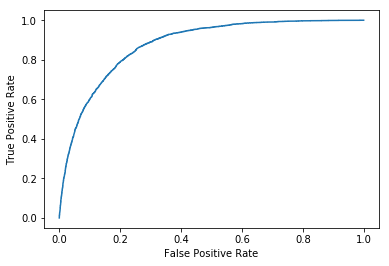

In [129]:
import matplotlib.pyplot as plt
plt.plot( fpr2, tpr2 )

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


plt.show()

In [118]:
from sklearn.metrics import roc_auc_score
roc_auc_score( y_test, y_pred[:, 1] )

0.8771213461783297

Средняя точно низкая, что говорит, что мы часто указываем на класс >50

In [119]:
from sklearn.metrics import average_precision_score
average_precision_score( y_test,y_pred[:, 1] )

0.6718819317199927

In [127]:
y_pred = bestlogreg.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test.values, y_pred, target_names=['<50','>50']))

             precision    recall  f1-score   support

        <50       0.86      0.93      0.89     11001
        >50       0.70      0.52      0.59      3395

avg / total       0.82      0.83      0.82     14396



Можем видеть, что на определении дохода < 50 модель справляется лучше